# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Imports

In [1]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Pipeline

In [2]:
def CannyProcess(image, filterSize, threshold1, threshold2):
    _filterSize = filterSize + (filterSize + 1) % 2
    smoothed_img = cv.GaussianBlur(image, (_filterSize, _filterSize), sigmaX=0, sigmaY=0)
    return cv.Canny(smoothed_img, threshold1, threshold2)

class _line:
    def __init__(self, slope, x1, y1, x2, y2):
        self.slope = slope
        self.x1 = x1 
        self.y1 = y1 
        self.x2 = x2 
        self.y2 = y2 


def _extend_line(line):
    line.x1 -= 2000
    line.y1 = int(line.y2 - line.slope * (line.x2 - line.x1))

    line.x2 += 2000
    line.y2 = int(line.slope * (line.x2 - line.x1) + line.y1)

    return line


def _get_avg_line(lines):
    lines.sort(key = lambda l : l.slope)
    while abs(lines[len(lines) // 2].slope - lines[-1].slope) > 0.5:
        lines.pop()
    while abs(lines[len(lines) // 2].slope - lines[0].slope) > 0.5:
        lines.pop(0)


def _get_avg_line(lines):
    lines.sort(key = lambda l : l.slope)
    while abs(lines[len(lines) // 2].slope - lines[-1].slope) > 0.5:
        lines.pop()
    while abs(lines[len(lines) // 2].slope - lines[0].slope) > 0.5:
        lines.pop(0)

    avg_line = _line(0, 0, 0, 0, 0) 
    for l in lines:
        avg_line.x1 += l.x1
        avg_line.y1 += l.y1
        avg_line.x2 += l.x2
        avg_line.y2 += l.y2

    avg_line.x1 = avg_line.x1 // len(lines)
    avg_line.y1 = avg_line.y1 // len(lines)
    avg_line.x2 = avg_line.x2 // len(lines)
    avg_line.y2 = avg_line.y2 // len(lines)
    avg_line.slope = (avg_line.y2 - avg_line.y1) / (avg_line.x2 - avg_line.x1)

    return _extend_line(avg_line)


def _get_lines(edges, threshold, minLineLength, maxLineGap):
    lines = cv.HoughLinesP(
        image = edges,
        rho = 1,
        theta = np.pi / 180,
        threshold = threshold,
        lines = np.array([]),
        minLineLength = minLineLength,
        maxLineGap = maxLineGap,
    )

    if lines is None:
        return (None, None)

    leftRawLines = []
    rightRawLines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1)
        if slope > 0:
            rightRawLines.append(_line(slope, x1, y1, x2, y2))
        else:
            leftRawLines.append(_line(slope, x1, y1, x2, y2))

    if len(leftRawLines) == 0 or len(rightRawLines) == 0:
        return (None, None)
    else:
        return (_get_avg_line(leftRawLines), _get_avg_line(rightRawLines))


def _getMask(image, points):
    mask = np.zeros_like(image)
    vertices = np.array(
        [points], 
        dtype=np.int32,
    )

    cv.fillPoly(mask, vertices, (255, 255, 255))
    return mask


def _get_triangle_vertices(image, base, height):
    x0 = int((image.shape[1] - base) / 2)
    x1 = x0 + base
    x2 = int(image.shape[1] / 2)
    y0 = y1 = image.shape[0]
    y2 = image.shape[0] - height 
    return [
            (x0, y0),
            (x1, y1),
            (x2, y2),
    ]


def LinesProcess(
    image,
    edges,
    topCut,
    bottomCut,
    base,
    height,
    pointsThs,
    minLineLength,
    maxLineGap,
):
    _bottomCut = edges.shape[0] - bottomCut
    triangleMask = _getMask(
        image = edges,
        points = _get_triangle_vertices(
            image = edges, 
            base = base, 
            height = height
        ),
    )

    cutMask = _getMask(
        image = edges,
        points = [
            (0, topCut),
            (0, _bottomCut),
            (edges.shape[1], _bottomCut),
            (edges.shape[1], topCut),
        ],
    )

    colorTriangleMask = np.dstack((triangleMask, triangleMask, triangleMask))
    colorCutMask = np.dstack((cutMask, cutMask, cutMask))

    maskedEdges = edges & triangleMask & cutMask
    maskedImage = image & colorTriangleMask & colorCutMask

    lLine, rLine = _get_lines(
        edges = maskedEdges,
        threshold = pointsThs,
        minLineLength = minLineLength,
        maxLineGap = maxLineGap,
    )

    if lLine is None:
        return (
            maskedImage,
            np.dstack((maskedEdges, maskedEdges, maskedEdges)),
            image
        )

    line_image = np.copy(image) * 0

    cv.line(line_image, (lLine.x1, lLine.y1), (lLine.x2, lLine.y2), (255, 0, 0), 10)
    cv.line(line_image, (rLine.x1, rLine.y1), (rLine.x2, rLine.y2), (255, 0, 0), 10)
    line_image = line_image & colorTriangleMask & colorCutMask

    colorEdges = np.dstack((maskedEdges, maskedEdges, maskedEdges))
    lineEdges = cv.addWeighted(colorEdges, 1, line_image, 0.8, 0)
    lineImage = cv.addWeighted(image, 1, line_image, 0.8, 0)
    return (maskedImage, lineEdges, lineImage)


def process_image(image):
    edges = CannyProcess(
        image = cv.cvtColor(image, cv.COLOR_RGB2GRAY),
        filterSize = 7,
        threshold1 = 35,
        threshold2 = 135,
    )
    _, _, ans = LinesProcess(
        image = image, 
        edges = edges,
        topCut = 0,
        bottomCut = 0,
        base = 853,
        height = 243,
        pointsThs = 41,
        minLineLength = 70,
        maxLineGap = 140,
    )
    return ans


def process_image_challenge(image):
    edges = CannyProcess(
        image = cv.cvtColor(image, cv.COLOR_RGB2GRAY),
        filterSize = 13,
        threshold1 = 59,
        threshold2 = 139,
    )
    _, _, ans = LinesProcess(
        image = image, 
        edges = edges,
        topCut = 457,
        bottomCut = 50,
        base = 1123,
        height = 338,
        pointsThs = 20,
        minLineLength = 20,
        maxLineGap = 56,
    )
    return ans

## Test on images

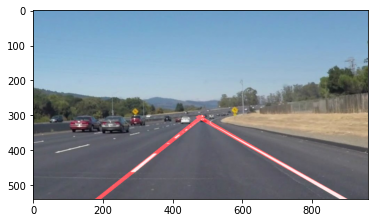

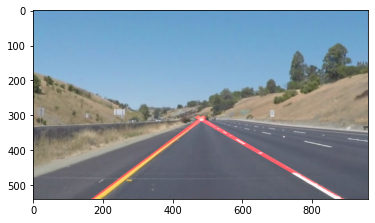

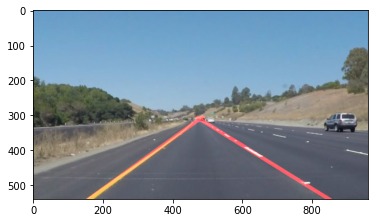

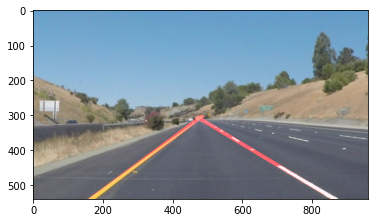

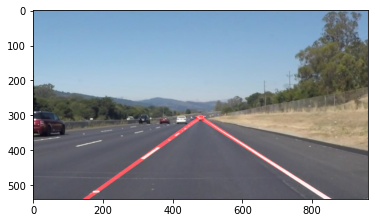

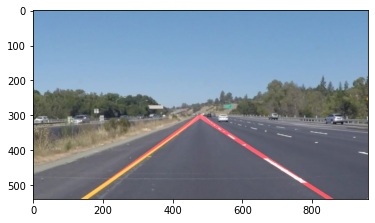

In [3]:
output_dir = 'test_images_output/'
input_dir = 'test_images/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

for i in os.listdir(input_dir):
    image_path = input_dir + i
    image = mpimg.imread(image_path)
    output_image = process_image(image)
    mpimg.imsave(output_dir + i, output_image)
    plt.figure(i)
    plt.imshow(output_image)

## Test on Videos

In [4]:
input_dir = 'test_videos/'
output_dir = 'test_videos_output/'
videos = []
    
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

for i in os.listdir(input_dir):
    #Unfortunatelly couldn't identify the yellow line
    #on the concrete in the challenge video.
    #Hope I can learn this technic along the course :)
    func = process_image_challenge if i == 'challenge.mp4' else process_image
    clip = VideoFileClip(input_dir + i)
    videos.append(clip.fl_image(func))
    videos[-1].write_videofile(output_dir + i, audio=False)

t:   2%|▏         | 4/251 [00:00<00:06, 38.86it/s, now=None]Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4


In [5]:
HTML("""
        <video width="960" height="540" controls>
        <source src="{0}">
        </video>
""".format(videos[0]))

In [6]:
HTML("""
        <video width="960" height="540" controls>
        <source src="{0}">
        </video>
""".format(videos[1]))

In [7]:
HTML("""
        <video width="960" height="540" controls>
        <source src="{0}">
        </video>
""".format(videos[2]))